Données Multimedia - Projet non-alternant - Module AUDIO
==============
---

# 0.a Imports et connection google drive

In [ ]:
import os
import json
import torch
import joblib
import librosa
import torchaudio

import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow import keras
from google.colab import drive
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
corpus_dir = "/content/drive/MyDrive/Projet non-alternant/Corpus/"
csv_dir = "/content/drive/MyDrive/Projet non-alternant/Corpus/csv/"
json_dir = "/content/drive/MyDrive/Projet non-alternant/Corpus/json/"
working_dir = "/content/drive/MyDrive/Projet non-alternant/Audio/CNN/"
features_dir = "/content/drive/MyDrive/Projet non-alternant/Audio/CNN/features/"
audio_dir = "/content/drive/MyDrive/Projet non-alternant/Corpus/train_val_videos/TrainValAudio/"

# 0.b Fonctions de reproductibilité

In [ ]:
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = get_device()
device

'cuda'

In [ ]:
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(42)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# 0.c Generation features mel

In [ ]:
SR = 16000
DURATION = 30.0
N_MELS = 64
N_FFT = 1024
HOP_LENGTH = 512

In [ ]:
train_csv = os.path.join(csv_dir, "train_audio_labels.csv")
val_csv = os.path.join(csv_dir, "val_audio_labels.csv")

train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)

In [ ]:
test_csv = os.path.join(csv_dir, "test_audio_labels.csv")

test_df = pd.read_csv(test_csv)

In [ ]:
encoder = LabelEncoder()
train_df["label_enc"] = encoder.fit_transform(train_df["label"])
val_df["label_enc"] = encoder.transform(val_df["label"])
test_df["label_enc"] = encoder.transform(test_df["label"])
num_classes = len(encoder.classes_)

In [ ]:
mel_spec_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    n_mels=N_MELS
).to(device)

amplitude_to_db = torchaudio.transforms.AmplitudeToDB().to(device)

In [ ]:
def process_audio(video_id):
    path = os.path.join(audio_dir, f"{video_id}.wav")
    if not os.path.exists(path):
        print("Missing:", path)
        return None
    waveform, sr = torchaudio.load(path)
    waveform = waveform.mean(dim=0, keepdim=True)  # mono
    waveform = torchaudio.functional.resample(waveform, sr, SR)

    max_len = int(SR * DURATION)
    if waveform.shape[1] < max_len:
        pad = max_len - waveform.shape[1]
        waveform = torch.nn.functional.pad(waveform, (0, pad))
    else:
        waveform = waveform[:, :max_len]

    waveform = waveform.to(device)
    mel_spec = mel_spec_transform(waveform)
    log_mel_spec = amplitude_to_db(mel_spec)
    return log_mel_spec.cpu().numpy()

In [ ]:
def process_dataset(df, split_name):
    X, y = [], []
    for i, row in df.iterrows():
        feat = process_audio(row["video_id"])
        if feat is None:
            continue
        X.append(feat)
        y.append(row["label_enc"])
        if i % 100 == 0:
            print(f"[{split_name}] Processed {i}/{len(df)}")
    X = np.array(X)[..., np.newaxis]
    y = np.array(y)
    return X, y

In [ ]:
print("Processing train dataset...")
X_train, y_train = process_dataset(train_df, "train")
print("Processing validation dataset...")
X_val, y_val = process_dataset(val_df, "val")

Processing train dataset...


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

[train] Processed 0/5728
[train] Processed 100/5728
[train] Processed 200/5728
[train] Processed 300/5728
[train] Processed 400/5728
[train] Processed 500/5728
[train] Processed 600/5728
[train] Processed 700/5728
[train] Processed 800/5728
[train] Processed 900/5728
[train] Processed 1000/5728
[train] Processed 1100/5728
[train] Processed 1200/5728
[train] Processed 1300/5728
[train] Processed 1400/5728
[train] Processed 1500/5728
[train] Processed 1600/5728
[train] Processed 1700/5728
[train] Processed 1800/5728
[train] Processed 1900/5728
[train] Processed 2000/5728
[train] Processed 2100/5728
[train] Processed 2200/5728
[train] Processed 2300/5728
[train] Processed 2400/5728
[train] Processed 2500/5728
[train] Processed 2600/5728
[train] Processed 2700/5728
[train] Processed 2800/5728
[train] Processed 2900/5728
[train] Processed 3000/5728
[train] Processed 3100/5728
[train] Processed 3200/5728
[train] Processed 3300/5728
[train] Processed 3400/5728
[train] Processed 3500/5728
[tra

In [ ]:
audio_dir = "/content/drive/MyDrive/Projet non-alternant/Corpus/test_videos/TestAudio/"

In [ ]:
print("Processing validation dataset...")
X_test, y_test = process_dataset(test_df, "test")

Processing validation dataset...


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

[test] Processed 0/2635
[test] Processed 100/2635
[test] Processed 200/2635
[test] Processed 300/2635
[test] Processed 400/2635
[test] Processed 500/2635
[test] Processed 600/2635
[test] Processed 700/2635
[test] Processed 800/2635
[test] Processed 900/2635
[test] Processed 1000/2635
[test] Processed 1100/2635
[test] Processed 1200/2635
[test] Processed 1300/2635
[test] Processed 1400/2635
[test] Processed 1500/2635
[test] Processed 1600/2635
[test] Processed 1700/2635
[test] Processed 1800/2635
[test] Processed 1900/2635
[test] Processed 2000/2635
[test] Processed 2100/2635
[test] Processed 2200/2635
[test] Processed 2300/2635
[test] Processed 2400/2635
[test] Processed 2500/2635
[test] Processed 2600/2635


In [ ]:
# ===== Save all features in one file =====
features_file = "/content/drive/MyDrive/Projet non-alternant/Audio/CNN/features_all.npz"
np.savez_compressed(features_file,
                    X_train=X_train, y_train=y_train,
                    X_val=X_val, y_val=y_val)
print(f"✅ All features saved to {features_file}")
print("Train shape:", X_train.shape, "Val shape:", X_val.shape)

✅ All features saved to /content/drive/MyDrive/Projet non-alternant/Audio/CNN/features_all.npz
Train shape: (5728, 1, 64, 938, 1) Val shape: (448, 1, 64, 938, 1)


In [ ]:
# ===== Save all features in one file =====
features_file = "/content/drive/MyDrive/Projet non-alternant/Audio/CNN/features_all_test.npz"
np.savez_compressed(features_file,
                    X_test=X_test, y_test=y_test)
print(f"✅ All features saved to {features_file}")
print("Test shape:", X_test.shape)

✅ All features saved to /content/drive/MyDrive/Projet non-alternant/Audio/CNN/features_all_test.npz
Test shape: (2635, 1, 64, 938, 1)


# 1. Train model

## Load features

In [ ]:
features_file = "/content/drive/MyDrive/Projet non-alternant/Audio/CNN/features/features_all.npz"
features_file_test = "/content/drive/MyDrive/Projet non-alternant/Audio/CNN/features_all_test.npz"
data = np.load(features_file)
data_test = np.load(features_file_test)
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data_test['X_test'], data_test['y_test']

if X_train.ndim == 5:
    X_train = X_train.squeeze(1)
    X_val = X_val.squeeze(1)
    X_test = X_test.squeeze(1)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (5728, 64, 938, 1)
Val shape: (448, 64, 938, 1)
Test shape: (2635, 64, 938, 1)


In [ ]:
max_frames_10s = 312
X_train = X_train[:, :, :max_frames_10s, :]
X_val   = X_val[:, :, :max_frames_10s, :]
X_test   = X_test[:, :, :max_frames_10s, :]


print("New shapes:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)

New shapes:
X_train: (5728, 64, 312, 1)
X_val: (448, 64, 312, 1)
X_test: (2635, 64, 312, 1)


## Example

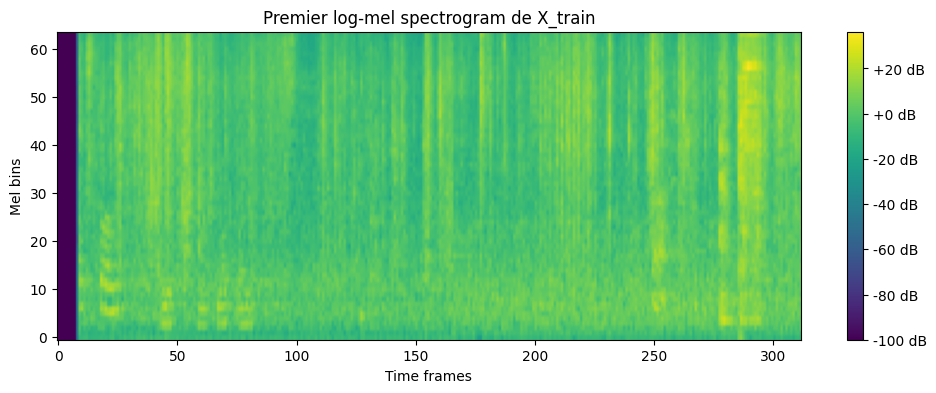

In [ ]:
# Premier log-mel spectrogram
mel = X_train[0]  # shape (1, 64, 938, 1)

# Supprimer les dimensions inutiles
mel = mel.squeeze()  # shape devient (64, 938)

# Affichage
plt.figure(figsize=(12, 4))
plt.imshow(mel, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(format="%+2.0f dB")
plt.title("Premier log-mel spectrogram de X_train")
plt.xlabel("Time frames")
plt.ylabel("Mel bins")
plt.show()

## Model

## Class distribution

In [ ]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=classes,
                                     y=y_train)
class_weights = dict(zip(classes, class_weights))
class_weights

{np.int64(0): np.float64(0.7381443298969073),
 np.int64(1): np.float64(2.045714285714286),
 np.int64(2): np.float64(1.0931297709923664),
 np.int64(3): np.float64(0.42938530734632685),
 np.int64(4): np.float64(0.9741496598639455),
 np.int64(5): np.float64(1.8012578616352202),
 np.int64(6): np.float64(1.79),
 np.int64(7): np.float64(0.5151079136690647),
 np.int64(8): np.float64(1.6),
 np.int64(9): np.float64(0.6004192872117401),
 np.int64(10): np.float64(0.939016393442623),
 np.int64(11): np.float64(1.8012578616352202),
 np.int64(12): np.float64(1.344600938967136),
 np.int64(13): np.float64(0.7889807162534436),
 np.int64(14): np.float64(0.895),
 np.int64(15): np.float64(2.952577319587629),
 np.int64(16): np.float64(0.7124378109452736),
 np.int64(17): np.float64(1.4464646464646465),
 np.int64(18): np.float64(0.9298701298701298),
 np.int64(19): np.float64(3.5358024691358025)}

In [ ]:
idx_to_label = {
    0: "music",
    1: "people",
    2: "gaming",
    3: "sports/actions",
    4: "news/events/politics",
    5: "education",
    6: "tv shows",
    7: "movie/comedy",
    8: "animation",
    9: "vehicles/autos",
    10: "howto",
    11: "travel",
    12: "science/technology",
    13: "animals/pets",
    14: "kids/family",
    15: "documentary",
    16: "food/drink",
    17: "cooking",
    18: "beauty/fashion",
    19: "advertisement"
}

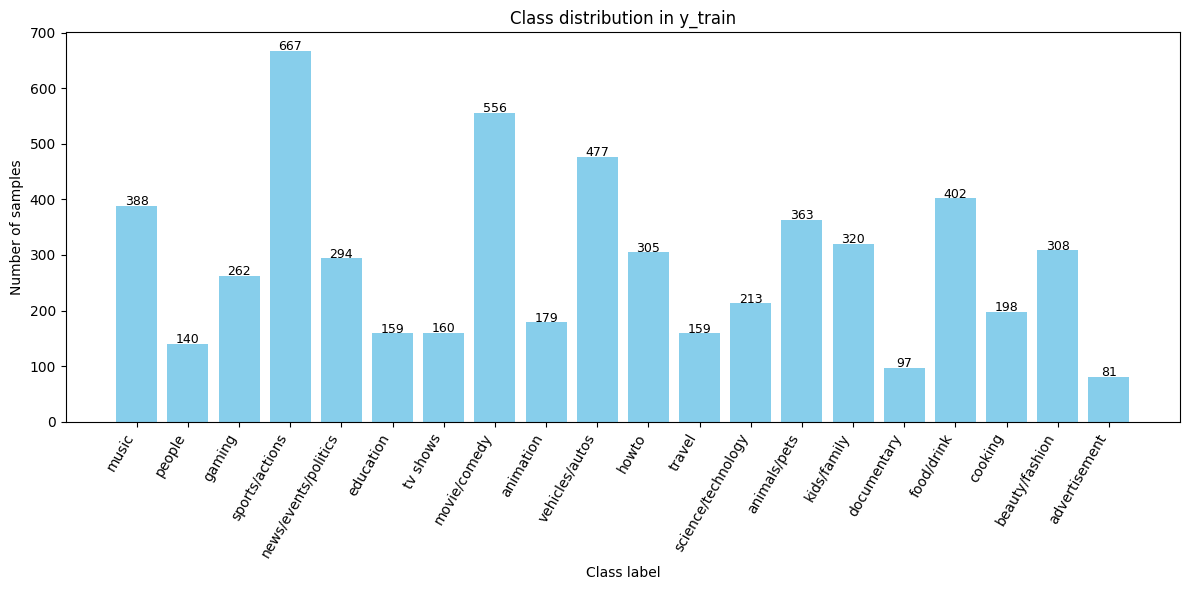

In [ ]:
# Distribution des classes
unique, counts = np.unique(y_train, return_counts=True)

# Conversion des indices en labels
labels = [idx_to_label[i] for i in unique]

# Tracé du graphique
plt.figure(figsize=(12, 6))
plt.bar(labels, counts, color='skyblue')
plt.title("Class distribution in y_train")
plt.xlabel("Class label")
plt.ylabel("Number of samples")
plt.xticks(rotation=60, ha='right')

# Annotation des barres
for i, count in enumerate(counts):
    plt.text(i, count + 1, str(count), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

## CNN Model

In [ ]:
def build_resnet_audio(input_shape, num_classes):

    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.2)(x)

    def res_block(x, filters):
        shortcut = x
        x = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, (3,3), padding='same')(x)
        x = layers.BatchNormalization()(x)

        if shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, (1,1), padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        x = layers.add([shortcut, x])
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D((2,2))(x)
        x = layers.Dropout(0.3)(x)
        return x

    x = res_block(x, 64)
    x = res_block(x, 128)
    x = res_block(x, 256)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    optimizer = tf.keras.optimizers.AdamW(
    learning_rate=1e-4,
    weight_decay=1e-5)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
model = build_resnet_audio(X_train.shape[1:], num_classes=20)
model.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31      │ (None, 64, 312,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_173 (Conv2D) │ (None, 64, 312,   │        640 │ input_layer_31[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 312,   │        256 │ conv2d_173[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_77    │ (None, 32, 156,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_110         │ (None, 32, 156,   │          0 │ max_pooling2d_77… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_174 (Conv2D) │ (None, 32, 156,   │     18,464 │ dropout_110[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 156,   │        128 │ conv2d_174[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_176 (Conv2D) │ (None, 32, 156,   │      2,080 │ dropout_110[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_175 (Conv2D) │ (None, 32, 156,   │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 156,   │        128 │ conv2d_176[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 156,   │        128 │ conv2d_175[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_49 (Add)        │ (None, 32, 156,   │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_86       │ (None, 32, 156,   │          0 │ add_49[0][0]      │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_78    │ (None, 16, 78,    │          0 │ activation_86[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_111         │ (None, 16, 78,    │          0 │ max_pooling2d_78… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_177 (Conv2D) │ (None, 16, 78,    │     18,496 │ dropout_111[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 78,    │        256 │ conv2d_177[0][0]

 Total params: 1,312,948 (5.01 MB)

 Trainable params: 1,309,940 (5.00 MB)

 Non-trainable params: 3,008 (11.75 KB)

## Train

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    shuffle=True
    )

Epoch 1/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.0831 - loss: 3.2846 - val_accuracy: 0.1183 - val_loss: 2.8703
Epoch 2/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.1219 - loss: 2.8499 - val_accuracy: 0.1629 - val_loss: 2.8754
Epoch 3/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.1362 - loss: 2.8031 - val_accuracy: 0.0960 - val_loss: 2.9311
Epoch 4/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.1508 - loss: 2.7630 - val_accuracy: 0.1250 - val_loss: 2.8850
Epoch 5/100
 75/179 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.1420 - loss: 2.7747

KeyboardInterrupt: 

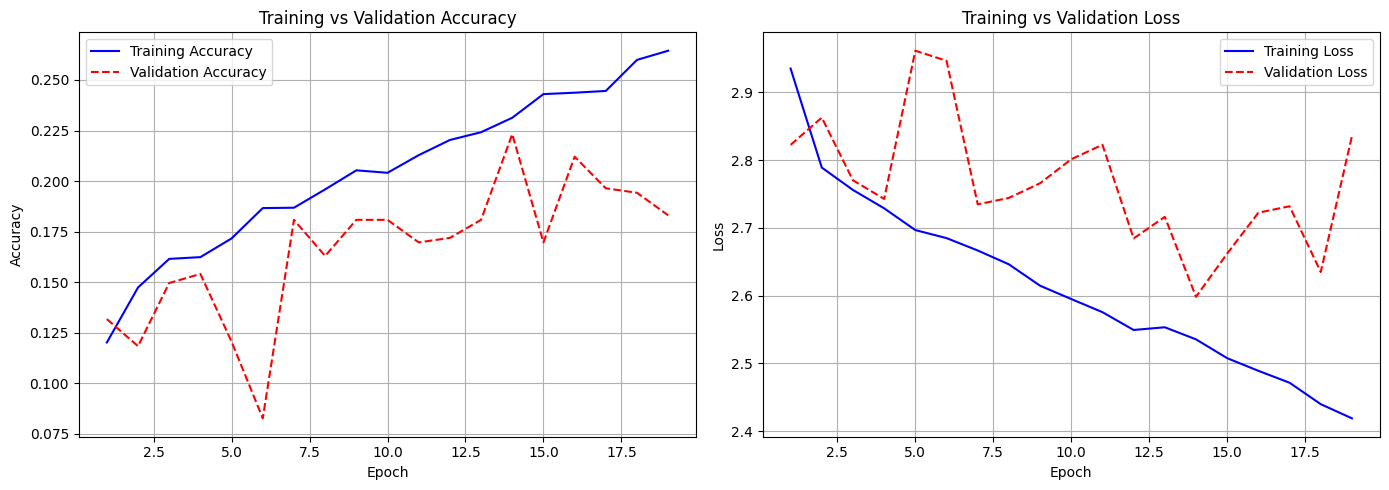

In [ ]:
def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


plot_training_curves(history)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
=== Validation Classification Report ===
              precision    recall  f1-score   support

           0      0.214     0.500     0.300        18
           1      0.000     0.000     0.000        15
           2      0.286     0.174     0.216        23
           3      0.315     0.348     0.331        66
           4      0.175     0.350     0.233        20
           5      0.000     0.000     0.000        12
           6      0.000     0.000     0.000        15
           7      0.236     0.553     0.331        38
           8      0.000     0.000     0.000        10
           9      0.433     0.302     0.356        43
          10      0.071     0.045     0.056        22
          11      0.500     0.125     0.200        16
          12      0.200     0.053     0.083        19
          13      0.250     0.080     0.121        25
          14      0.250     0.040     0.069        25
          15  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

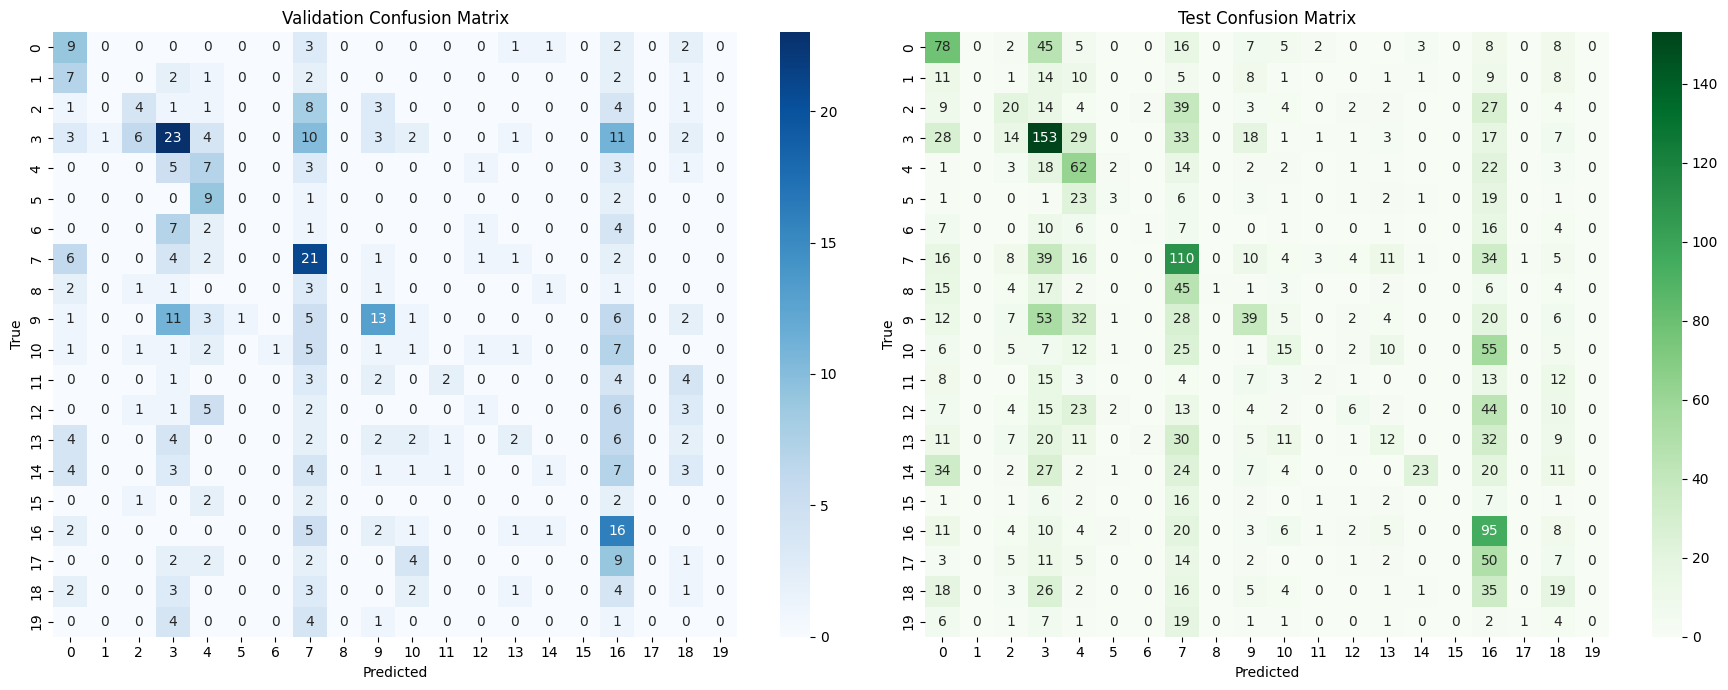

In [ ]:
y_pred_val = np.argmax(model.predict(X_val), axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1)

print("=== Validation Classification Report ===")
print(classification_report(y_val, y_pred_val, digits=3))

print("\n=== Test Classification Report ===")
print(classification_report(y_test, y_pred_test, digits=3))

cm_val = confusion_matrix(y_val, y_pred_val)
cm_test = confusion_matrix(y_test, y_pred_test)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(cm_val, annot=True, cmap="Blues", fmt='d', ax=axes[0])
axes[0].set_title("Validation Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(cm_test, annot=True, cmap="Greens", fmt='d', ax=axes[1])
axes[1].set_title("Test Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()